In [1]:
import math
import copy
import pickle
import numpy as np
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
device = torch.device('mps')
seed = 1
np.random.seed(seed)

In [3]:
def load_datasets(filename="dataset.pkl"):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data["datasets"], data["time_points"]

datasets, time_points = load_datasets('dataset.pkl')

In [4]:
data_subsets = []

# Iterate through the original datasets and their index
for idx, (X_t, y_t) in enumerate(datasets):
    # Create a dictionary for the current domain
    domain_data = {
        'idx': idx,                             # Domain index (e.g., 0, 1, 2)
        'X_data': X_t,                          # The data points (e.g., NumPy array or tensor)
        'y_labels': y_t,                        # The corresponding categories/labels
        'time': time_points[idx],               # The associated time point for this domain
        'domain_name': f"Domain {idx+1}"        # A descriptive name
    }
    
    # Add the organized subset to the main list
    data_subsets.append(domain_data)

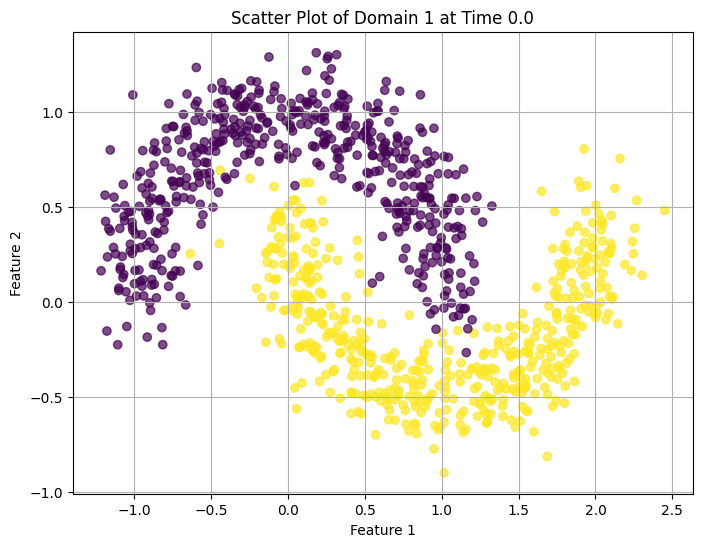

In [17]:
domain_1 = data_subsets[0]
X_data_1 = domain_1['X_data']
y_labels_1 = domain_1['y_labels']
time_1 = domain_1['time']
domain_name_1 = domain_1['domain_name']

#visualize the first domain
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_data_1[:, 0], X_data_1[:, 1], c=y_labels_1, cmap='viridis', alpha=0.7)
plt.title(f'Scatter Plot of {domain_name_1} at Time {time_1}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.grid(True)
plt.show()

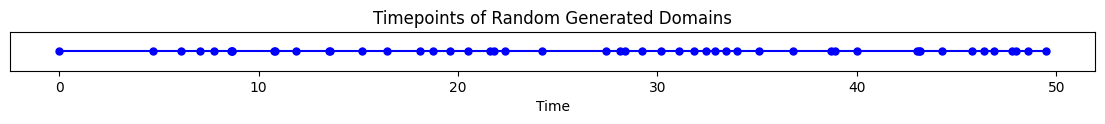

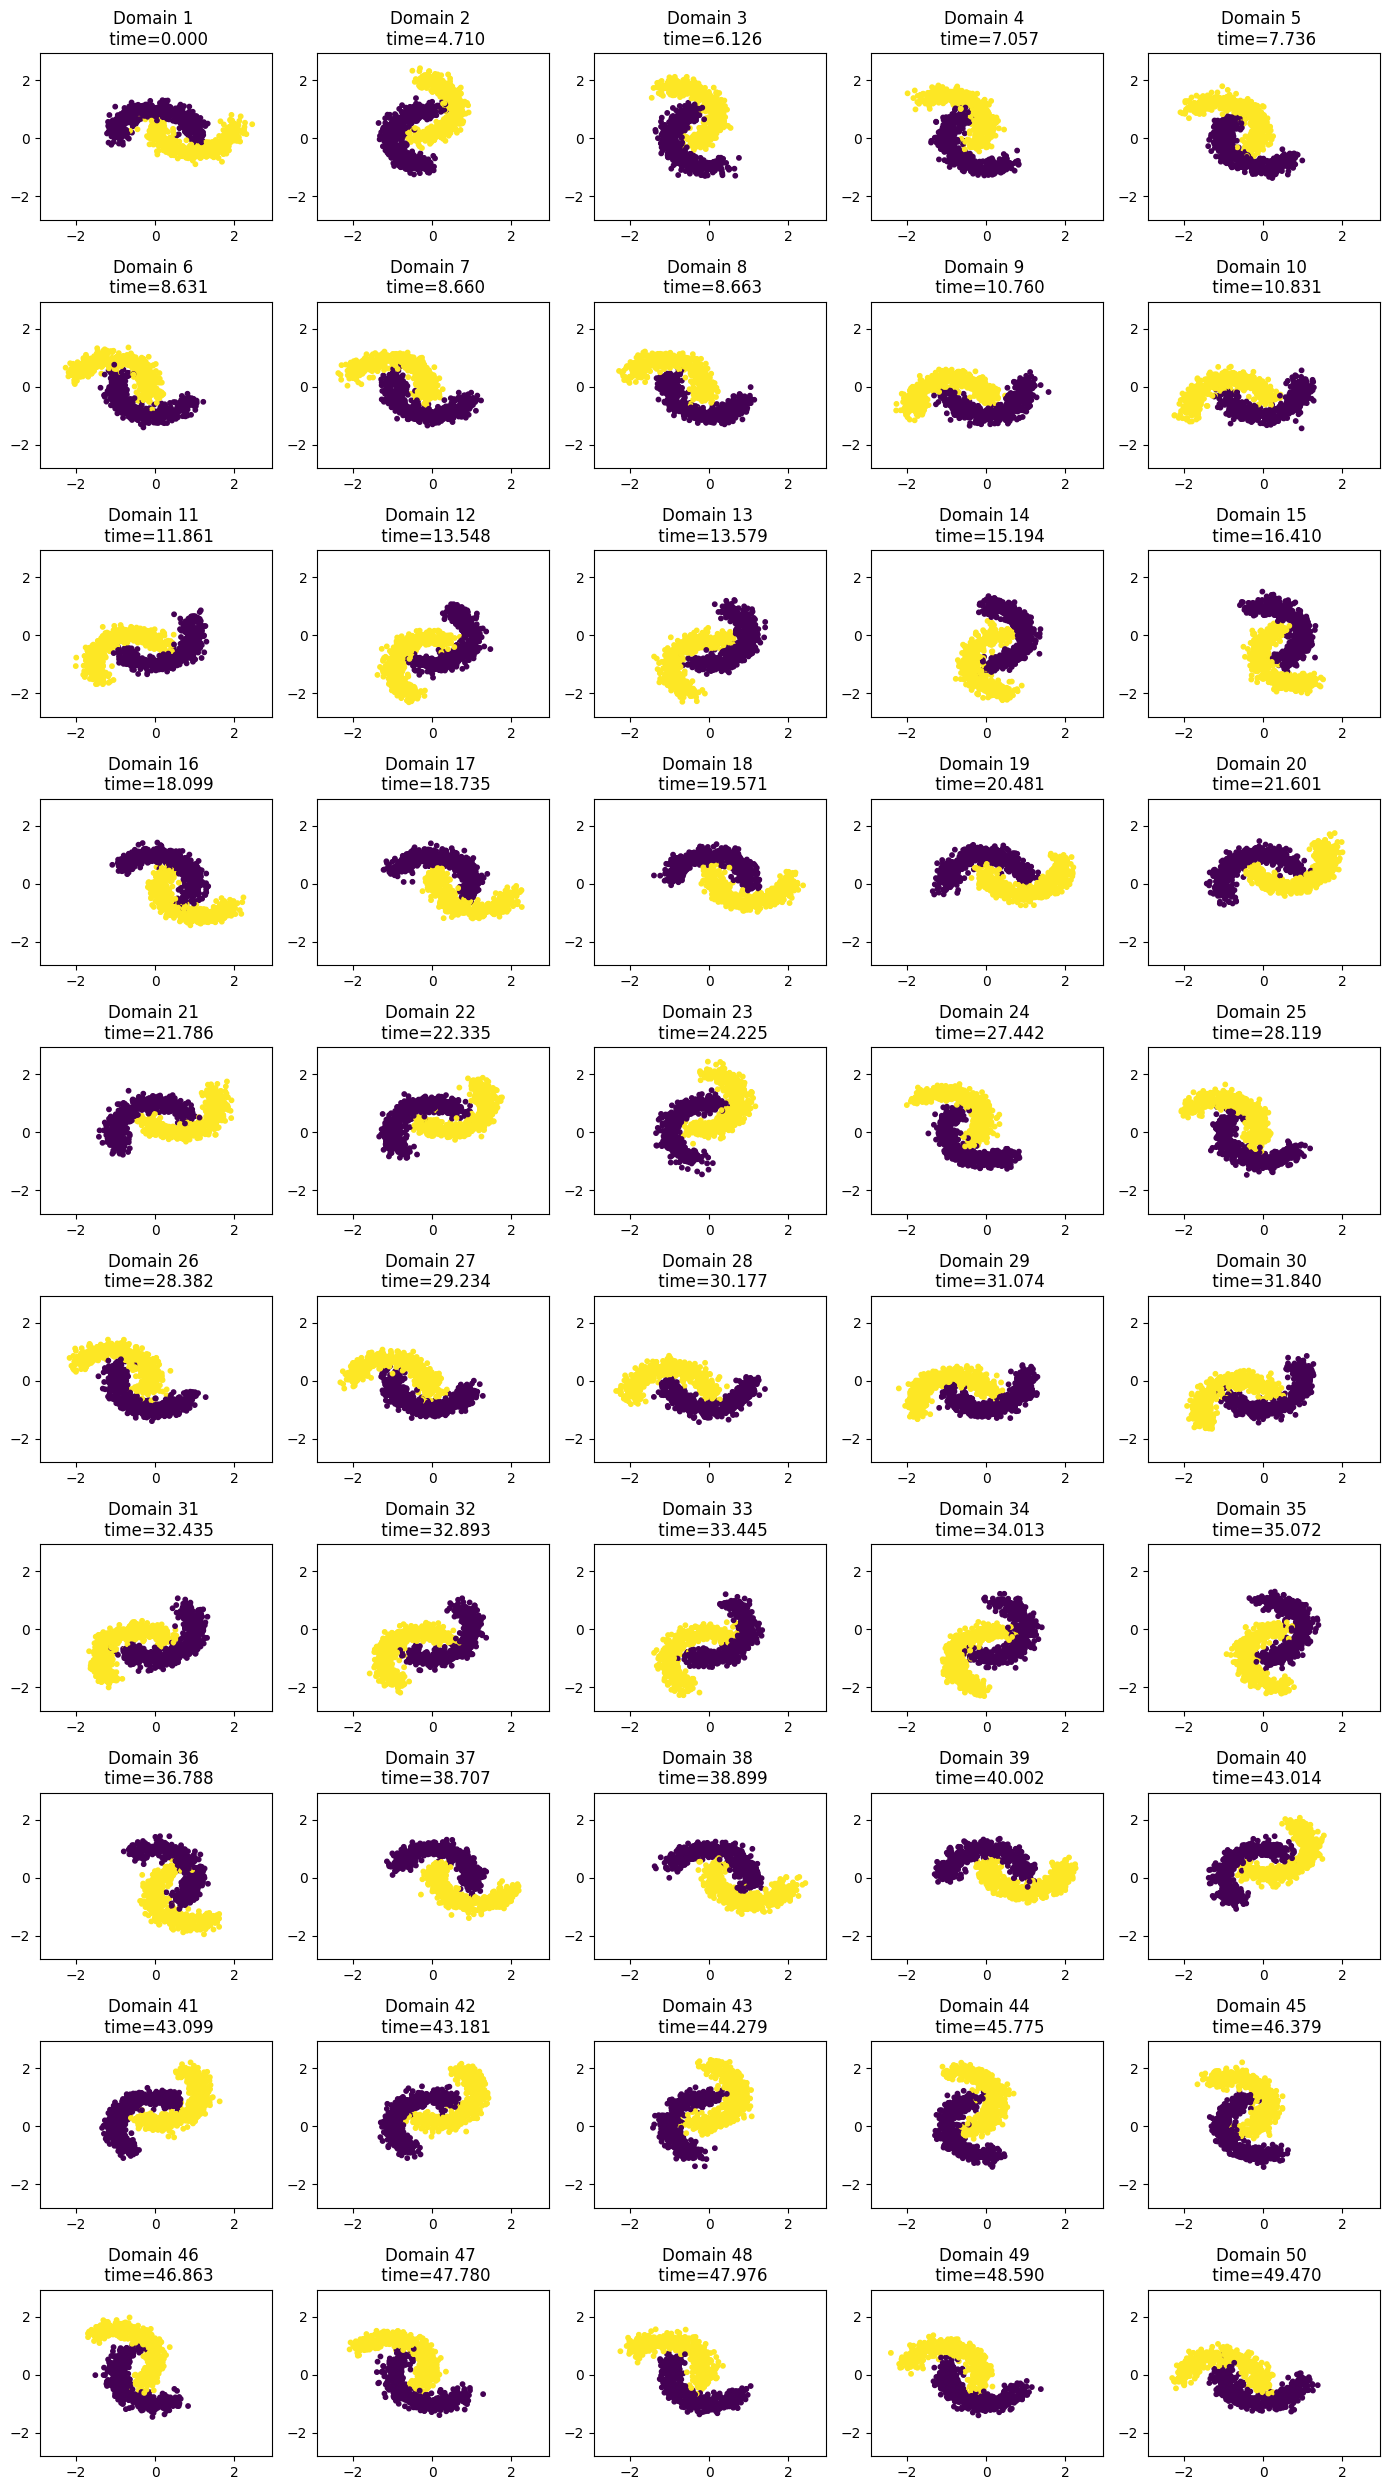

In [7]:
def visualize_moon(datasets, time_points):
    ndomamins = len(time_points)
    ncols = 5
    nrows = math.ceil(ndomamins / ncols)
    
    fig, axs = plt.subplots(figsize=(14, 2.5 * nrows), nrows=nrows, ncols=ncols)
    axs = axs.ravel()

    all_data = np.vstack([data for data, _ in datasets])
    x_min, x_max = all_data[:, 0].min() - 0.5, all_data[:, 0].max() + 0.5
    y_min, y_max = all_data[:, 1].min() - 0.5, all_data[:, 1].max() + 0.5

    for idx, (X_t, y_t) in enumerate(datasets):
        axs[idx].scatter(X_t[:, 0], X_t[:, 1], s=10, c=y_t)
        axs[idx].set_xlim([x_min, x_max])
        axs[idx].set_ylim([y_min, y_max])
        axs[idx].set_title(f"Domain {idx+1} \n time={time_points[idx]:.3f}")
    plt.tight_layout()
    plt.show()
    
def visualize_time(time_points):
    plt.figure(figsize=(14, 0.5))
    plt.plot(time_points, np.zeros_like(time_points), 'bo-', label="Domains", markersize=5)
    plt.yticks([])
    
    plt.xlabel("Time")
    plt.title("Timepoints of Random Generated Domains")
    plt.show()

visualize_time(time_points)            # visualize moments of randomly selected domains
visualize_moon(datasets, time_points)  # visualize each domain


In [2]:
# Check which Python interpreter is being used
import sys
print(sys.executable)

# Check all installed packages in that specific environment
!{sys.executable} -m pip show pyro-ppl

/opt/homebrew/anaconda3/envs/two_moon_DG/bin/python


In [3]:
!pip install pyro-ppl

  Using cached pyro_ppl-1.9.1-py3-none-any.whl.metadata (7.8 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached pyro_api-0.1.2-py3-none-any.whl.metadata (2.5 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached pyro_ppl-1.9.1-py3-none-any.whl (755 kB)
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
Using cached pyro_api-0.1.2-py3-none-any.whl (11 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pyro-ppl]3/4 [pyro-ppl]


In [5]:
!pip install seaborn

In [8]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
smoke_test = ('CI' in os.environ)

$$
x_0 \sim \text{Gaussian}(\mu_0, \Sigma_0) \\
x_{t+1} = A_t x_t + b_t + \epsilon_{t+1}^1 \\
z_t = C_t x_t + d_t + \epsilon_t^2 \\
\epsilon_t^1 \sim \text{Gaussian}(0, Q) \\
\epsilon_t^2 \sim \text{Gaussian}(0, R)
$$

In the case of the additive noise model,
$$
x_0 \sim \text{Gaussian}(\mu_0, \Sigma_0) \\
x_{t+1} = f_t(x_t) + \epsilon_{t+1}^1 \\
z_t = g_t(x_t) + \epsilon_t^2 \\
\epsilon_t^1 \sim \text{Gaussian}(0, Q) \\
\epsilon_t^2 \sim \text{Gaussian}(0, R)
$$

The general model is nearly the same, except with the following modifications,
$$
x_{t+1} = f_t(x_t, \epsilon_{t+1}^1) \\
z_t = g_t(x_t, \epsilon_t^2)
$$

In [5]:
!pip install pykalman

  Using cached pykalman-0.10.2-py2.py3-none-any.whl.metadata (9.6 kB)
  Using cached scikit_base-0.12.6-py3-none-any.whl.metadata (8.8 kB)
Using cached pykalman-0.10.2-py2.py3-none-any.whl (249 kB)
Using cached scikit_base-0.12.6-py3-none-any.whl (149 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pykalman]


In [6]:
import numpy as np
from pykalman import KalmanFilter

In [7]:
# --- 2. Pre-processing: Adapt Data for Kalman Filter ---

# The KF tracks one vector, so we track the *mean* of the point cloud.
# 'measurements' will be shape (n_timesteps, 2)
measurements = np.array(
    [d['X_data'].mean(axis=0) for d in data_subsets]
)

# Get the list of time points and number of steps
times = np.array([d['time'] for d in data_subsets])
n_timesteps = len(times)

# --- 3. Build Time-Varying Transition Matrices ---

# Calculate the time difference 'dt' between each step
# dts will have length n_timesteps - 1
dts = np.diff(times)

# State is [x_pos, y_pos, x_vel, y_vel]
n_dim_state = 4
n_dim_obs = 2

# Create a *list* of transition matrices
# One matrix for each dt_k
transition_matrices_list = []
for dt in dts:
    F = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    transition_matrices_list.append(F)

# Convert the list to a NumPy array of shape (n_timesteps-1, 4, 4)
# This is what pykalman expects for a time-varying model
transition_matrices_list = np.array(transition_matrices_list)

# --- 4. Initialize and Run the Kalman Filter ---

# Observation matrix is constant: we only observe position
observation_matrix = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

# We must give the process noise (Q) a high variance,
# especially for velocity. This tells the filter
# "I know my constant velocity model is wrong, expect big changes."
transition_covariance = np.eye(n_dim_state) * 0.1
transition_covariance[2, 2] = 10.0  # High noise for x_vel
transition_covariance[3, 3] = 10.0  # High noise for y_vel

# Observation noise (R)
observation_covariance = np.eye(n_dim_obs) * 0.1

# Initial state (position at t=0, velocity=0)
initial_state_mean = np.array([
    measurements[0, 0],
    measurements[0, 1],
    0,
    0
])

# Initialize the Kalman Filter
kf = KalmanFilter(
    n_dim_state=n_dim_state,
    n_dim_obs=n_dim_obs,
    
    # Pass the LIST of matrices
    transition_matrices=transition_matrices_list, 
    
    # Pass the single (constant) matrices
    observation_matrices=observation_matrix,
    transition_covariance=transition_covariance,
    observation_covariance=observation_covariance,
    initial_state_mean=initial_state_mean,
    
    # Fix for the 'NoneType' error
    transition_offsets=np.zeros(n_dim_state),
    observation_offsets=np.zeros(n_dim_obs)
)

# We can't use EM to learn 'transition_matrices' since we provided
# them, but we can learn the noise and initial state.
kf = kf.em(
    measurements, 
    n_iter=5,
    em_vars=[
        'transition_covariance', 
        'observation_covariance', 
        'initial_state_mean', 
        'initial_state_covariance'
    ]
)

# Run the filter over all measurements
(filtered_state_means, _) = kf.filter(measurements)

# --- 5. TASK: Predict State and Measurement for t=n+1 ---

# Get the last filtered state (the state at time n)
state_at_n_mean = filtered_state_means[-1]

print(f"Last time (t=n): {times[-1]:.3f}")
print(f"Last observed measurement (mean at t=n): \n{measurements[-1]}\n")
print(f"Filtered state estimate (at t=n): \n{state_at_n_mean}\n")

# To predict t=n+1, we need a 'dt'
# We'll assume the next time step is the same as the last one
dt_next = dts[-1] 
print(f"--- Predicting for t=n+1 (assuming dt={dt_next:.3f}) ---")

# Build the *next* transition matrix
F_next = np.array([
    [1, 0, dt_next, 0],
    [0, 1, 0, dt_next],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# TASK 1: "use the hidden state at t=n, to generate the state at t=n+1"
predicted_state_at_n_plus_1 = np.dot(
    F_next,
    state_at_n_mean
) + kf.transition_offsets

print(f"Predicted state (at t=n+1): \n{predicted_state_at_n_plus_1}\n")

# TASK 2: "use the hidden state to generate the y measurement at t=n+1"
generated_measurement_at_n_plus_1 = np.dot(
    kf.observation_matrices,
    predicted_state_at_n_plus_1
) + kf.observation_offsets

print(f"Generated (expected) measurement (at t=n+1): \n{generated_measurement_at_n_plus_1}\n")

Last time (t=n): 49.470
Last observed measurement (mean at t=n): 
[-0.53664705 -0.16626801]

Filtered state estimate (at t=n): 
[-0.54088042 -0.16619361  0.01093191 -0.17228863]

--- Predicting for t=n+1 (assuming dt=0.880) ---
Predicted state (at t=n+1): 
[-0.53126298 -0.31776586  0.01093191 -0.17228863]

Generated (expected) measurement (at t=n+1): 
[-0.53126298 -0.31776586]



In [12]:
all_measurements = np.array(
    [d['X_data'].mean(axis=0) for d in data_subsets]
)
all_times = np.array([d['time'] for d in data_subsets])

# --- CHANGED: Split the data ---
# We use the first 46 samples (index 0-45) for training
train_idx = 46
measurements_train = all_measurements[:train_idx]
times_train = all_times[:train_idx]

# The 46th sample (index 46) is our test point
measurement_test = all_measurements[train_idx]
time_test = all_times[train_idx]

print(f"Training on {len(measurements_train)} samples (indices 0-{train_idx-1}).")
print(f"Testing on 1 sample (index {train_idx}).\n")

# --- 3. Build Time-Varying Transition Matrices (for Training) ---

# --- CHANGED: Calculate dts for the training set only ---
# This will have (n_timesteps - 1) = 45 elements
dts_train = np.diff(times_train)

# State is [x_pos, y_pos, x_vel, y_vel]
n_dim_state = 4
n_dim_obs = 2

# Create a *list* of transition matrices
transition_matrices_list = []
for dt in dts_train:
    F = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    transition_matrices_list.append(F)

# Shape is now (45, 4, 4)
transition_matrices_list = np.array(transition_matrices_list)

# --- 4. Initialize and Run the Kalman Filter (on Training Data) ---

observation_matrix = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])
transition_covariance = np.eye(n_dim_state) * 0.1
transition_covariance[2, 2] = 10.0
transition_covariance[3, 3] = 10.0
observation_covariance = np.eye(n_dim_obs) * 0.1

# --- CHANGED: Initial state based on training data ---
initial_state_mean = np.array([
    measurements_train[0, 0],
    measurements_train[0, 1],
    0,
    0
])

kf = KalmanFilter(
    n_dim_state=n_dim_state,
    n_dim_obs=n_dim_obs,
    transition_matrices=transition_matrices_list, 
    observation_matrices=observation_matrix,
    transition_covariance=transition_covariance,
    observation_covariance=observation_covariance,
    initial_state_mean=initial_state_mean,
    transition_offsets=np.zeros(n_dim_state),
    observation_offsets=np.zeros(n_dim_obs)
)

# --- CHANGED: Use EM on training data only ---
kf = kf.em(
    measurements_train, 
    n_iter=5,
    em_vars=[
        'transition_covariance', 
        'observation_covariance', 
        'initial_state_mean', 
        'initial_state_covariance'
    ]
)

# --- CHANGED: Filter on training data only ---
(filtered_state_means, _) = kf.filter(measurements_train)

# --- 5. TASK: Predict for t=n+1 and EVALUATE ---

# Get the last filtered state (the state at time n=45)
state_at_n_mean = filtered_state_means[-1]
last_train_time = times_train[-1]

print(f"Last training time (t=n): {last_train_time:.3f}")
print(f"Filtered state estimate (at t=n): \n{state_at_n_mean}\n")

# --- CHANGED: Calculate the *true* dt for the prediction step ---
dt_for_prediction = time_test - last_train_time
print(f"--- Predicting for t=n+1 (time {time_test:.3f}) ---")
print(f"Using actual dt = {dt_for_prediction:.3f}\n")

# Build the *next* transition matrix using this specific dt
F_next = np.array([
    [1, 0, dt_for_prediction, 0],
    [0, 1, 0, dt_for_prediction],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# TASK 1: "use the hidden state at t=n, to generate the state at t=n+1"
predicted_state_at_n_plus_1 = np.dot(
    F_next,
    state_at_n_mean
) + kf.transition_offsets

print(f"Predicted state (at t=n+1): \n{predicted_state_at_n_plus_1}\n")

# TASK 2: "use the hidden state to generate the y measurement at t=n+1"
generated_measurement_at_n_plus_1 = np.dot(
    kf.observation_matrices,
    predicted_state_at_n_plus_1
) + kf.observation_offsets

# --- NEW: Evaluate Accuracy ---
actual_measurement = measurement_test

# Calculate the Euclidean distance between predicted and actual
prediction_error = np.linalg.norm(
    generated_measurement_at_n_plus_1 - actual_measurement
)

print("--- 🎯 Accuracy Evaluation ---")
print(f"Actual Measurement (at t=n+1): \n{actual_measurement}\n")
print(f"Predicted Measurement (at t=n+1): \n{generated_measurement_at_n_plus_1}\n")
print(f"Prediction Error (Distance): {prediction_error:.4f}")

Training on 46 samples (indices 0-45).
Testing on 1 sample (index 46).

Last training time (t=n): 46.863
Filtered state estimate (at t=n): 
[-0.49085333  0.28273792 -0.11879971 -0.12427618]

--- Predicting for t=n+1 (time 47.780) ---
Using actual dt = 0.916

Predicted state (at t=n+1): 
[-0.59970777  0.16886547 -0.11879971 -0.12427618]

--- 🎯 Accuracy Evaluation ---
Actual Measurement (at t=n+1): 
[-0.5400422   0.13481305]

Predicted Measurement (at t=n+1): 
[-0.59970777  0.16886547]

Prediction Error (Distance): 0.0687



Generating prediction cloud plot...


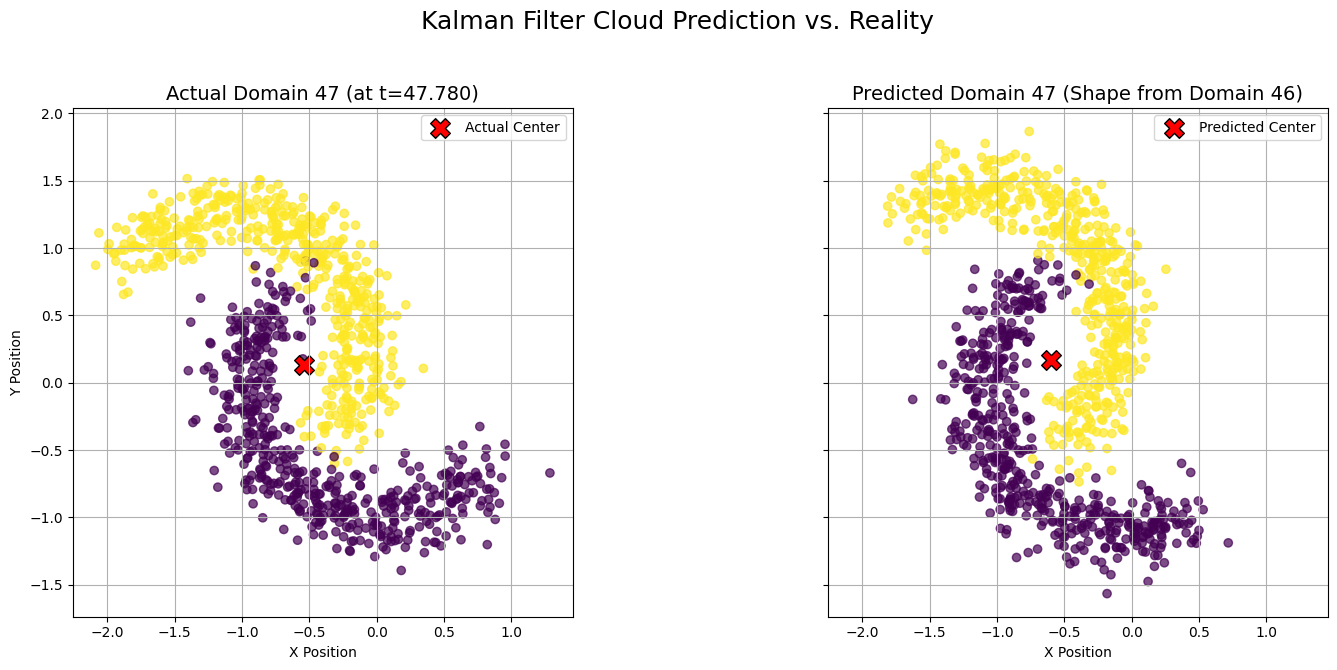

In [14]:
# --- 8. Plot the Predicted Cloud vs. Actual Cloud ---
# Get the last known cloud of points and their labels (from Domain 45)
# train_idx is 45, so the index for domain 45 is 44 (or train_idx - 1)
last_known_cloud = data_subsets[train_idx - 1]['X_data']
last_known_labels = data_subsets[train_idx - 1]['y_labels']
last_known_center = measurements_train[-1]

# Get the predicted center for Domain 46 (from Task 5)
predicted_center = generated_measurement_at_n_plus_1

# Calculate the translation vector
# This is the (x, y) difference between the predicted center
# and the last known center.
translation_vector = predicted_center - last_known_center

# Apply this translation to every point in the last known cloud
predicted_cloud = last_known_cloud + translation_vector

# Get the ACTUAL cloud and labels for Domain 46 for comparison
# The index for domain 46 is 45 (or train_idx)
actual_cloud = data_subsets[train_idx]['X_data']
actual_labels = data_subsets[train_idx]['y_labels']
actual_center = all_measurements[train_idx] # This is 'actual_measurement'
print("\nGenerating prediction cloud plot...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Subplot 1: The REAL Data
ax1.scatter(actual_cloud[:, 0], actual_cloud[:, 1], c=actual_labels, alpha=0.7)
ax1.scatter(actual_center[0], actual_center[1], c='red', s=200, marker='X', label='Actual Center', edgecolors='k')
ax1.set_title(f"Actual Domain 47 (at t={time_test:.3f})", fontsize=14)
ax1.set_xlabel("X Position")
ax1.set_ylabel("Y Position")
ax1.legend()
ax1.grid(True)
# --- FIX: Changed axis('equal') to set_aspect ---
ax1.set_aspect('equal', adjustable='box')

# Subplot 2: The PREDICTED Data
ax2.scatter(predicted_cloud[:, 0], predicted_cloud[:, 1], c=last_known_labels, alpha=0.7)
ax2.scatter(predicted_center[0], predicted_center[1], c='red', s=200, marker='X', label='Predicted Center', edgecolors='k')
ax2.set_title(f"Predicted Domain 47 (Shape from Domain 46)", fontsize=14)
ax2.set_xlabel("X Position")
ax2.legend()
ax2.grid(True)
# --- FIX: Added set_aspect here as well ---
ax2.set_aspect('equal', adjustable='box')

plt.suptitle("Kalman Filter Cloud Prediction vs. Reality", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()